In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv


# Load data 

In [3]:
import pandas 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

In [4]:
data="/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv"
df=pd.read_csv(data)

In [5]:
df.isnull().sum()

label      0
content    0
dtype: int64

In [6]:
df.duplicated().sum()

32

In [7]:
df = df.drop_duplicates()

In [8]:
df.duplicated().sum()

0

In [9]:
df.columns

Index(['label', 'content'], dtype='object')

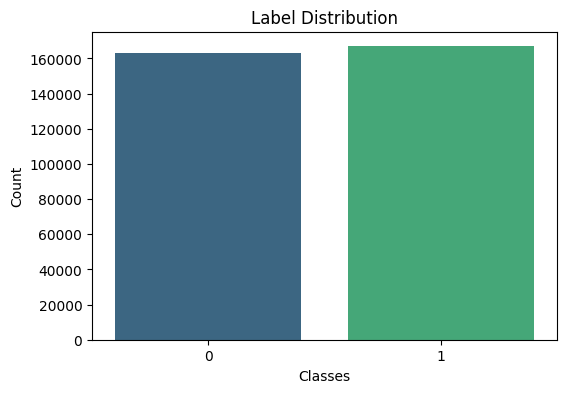

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [11]:
df.shape

(329968, 2)

# Split data

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= (train_test_split(
    df["content"],df["label"],test_size=0.3,random_state=42)
)

In [13]:
print(f"Number of train text: {len(X_train)}")
print(f"Number of test text: {len(X_test)}")

Number of train text: 230977
Number of test text: 98991


# BERT

Use a BERT Model to Embed the Data

In [14]:
X_train = X_train.tolist()  
X_test = X_test.tolist()

In [15]:
import numpy as np
import torch
from transformers import BertTokenizer, BertModel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)


def get_bert_embeddings(texts, max_length=100, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
       
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}  

       
        with torch.no_grad():
            outputs = model(**inputs)

       
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(embeddings)
    
    return np.vstack(all_embeddings)


train_embeddings = get_bert_embeddings(X_train)
test_embeddings = get_bert_embeddings(X_test)


y_train = torch.tensor(np.array(y_train, dtype=np.float32), device=device).unsqueeze(1)
y_test = torch.tensor(np.array(y_test, dtype=np.float32), device=device).unsqueeze(1)


print(f"Train Embeddings Shape: {train_embeddings.shape}")  
print(f"Test Embeddings Shape: {test_embeddings.shape}")  
print(f"y_train shape: {y_train.shape}")  
print(f"y_test shape: {y_test.shape}")  


if len(train_embeddings.shape) == 2:
    train_embeddings = train_embeddings.reshape(train_embeddings.shape[0], 1, train_embeddings.shape[1])
    test_embeddings = test_embeddings.reshape(test_embeddings.shape[0], 1, test_embeddings.shape[1])

print(f"Reshaped Train Embeddings Shape: {train_embeddings.shape}")  
print(f"Reshaped Test Embeddings Shape: {test_embeddings.shape}")  


Using device: cuda


tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Train Embeddings Shape: (230977, 768)
Test Embeddings Shape: (98991, 768)
y_train shape: torch.Size([230977, 1])
y_test shape: torch.Size([98991, 1])
Reshaped Train Embeddings Shape: (230977, 1, 768)
Reshaped Test Embeddings Shape: (98991, 1, 768)


In [16]:
from torch.utils.data import DataLoader, TensorDataset


X_train_tensor = torch.tensor(train_embeddings, dtype=torch.float32).to(device)
y_train_tensor = y_train.to(device)
X_test_tensor = torch.tensor(test_embeddings, dtype=torch.float32).to(device)
y_test_tensor = y_test.to(device)


batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# RNN , LSTM ,BI directions LSTM ,BI directions RNN


# RNN model


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)

# LSTM model

In [19]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)

# Bi-Directional RNN model

In [20]:
class BiRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)


# Bi-Directional LSTM model

In [21]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return torch.sigmoid(out)

In [22]:
model_names = ['RNN', 'LSTM', 'Bidirectional RNN', 'Bidirectional LSTM']
model_classes = [RNNModel, LSTMModel, BiRNNModel, BiLSTMModel]


In [23]:

input_size = 768 
hidden_size = 128  
output_size = 1   
learning_rate = 0.001
num_epochs = 10

# Train and Evaliate the models

### RNN 

In [24]:

print("\n==== Training RNN Model ====")
rnn_model = RNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=learning_rate)
rnn_train_losses = []

for epoch in range(num_epochs):
    rnn_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = rnn_model(X_batch)
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    rnn_train_losses.append(avg_loss)
    print(f"RNN - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


rnn_model.eval()
rnn_preds = []
rnn_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = rnn_model(X_batch)
        preds = (outputs > 0.5).int()
        rnn_preds.extend(preds.cpu().numpy())
        rnn_labels.extend(y_batch.cpu().numpy())
rnn_accuracy = np.mean(np.array(rnn_preds) == np.array(rnn_labels))
print(f"RNN Test Accuracy: {rnn_accuracy:.4f}")
print(classification_report(rnn_labels, rnn_preds))

rnn_result = {
    'model': rnn_model,
    'train_losses': rnn_train_losses,
    'test_accuracy': rnn_accuracy,
    'classification_report': classification_report(rnn_labels, rnn_preds)
}


==== Training RNN Model ====
RNN - Epoch [1/10], Loss: 0.3235
RNN - Epoch [2/10], Loss: 0.3086
RNN - Epoch [3/10], Loss: 0.3065
RNN - Epoch [4/10], Loss: 0.3043
RNN - Epoch [5/10], Loss: 0.3032
RNN - Epoch [6/10], Loss: 0.3023
RNN - Epoch [7/10], Loss: 0.3009
RNN - Epoch [8/10], Loss: 0.3010
RNN - Epoch [9/10], Loss: 0.2993
RNN - Epoch [10/10], Loss: 0.2979
RNN Test Accuracy: 0.8835
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     48812
         1.0       0.89      0.88      0.88     50179

    accuracy                           0.88     98991
   macro avg       0.88      0.88      0.88     98991
weighted avg       0.88      0.88      0.88     98991



# LSTM Model

In [25]:

print("\n==== Training LSTM Model ====")
lstm_model = LSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
lstm_train_losses = []

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    lstm_train_losses.append(avg_loss)
    print(f"LSTM - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


lstm_model.eval()
lstm_preds = []
lstm_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = lstm_model(X_batch)
        preds = (outputs > 0.5).int()
        lstm_preds.extend(preds.cpu().numpy())
        lstm_labels.extend(y_batch.cpu().numpy())
lstm_accuracy = np.mean(np.array(lstm_preds) == np.array(lstm_labels))
print(f"LSTM Test Accuracy: {lstm_accuracy:.4f}")
print(classification_report(lstm_labels, lstm_preds))

lstm_result = {
    'model': lstm_model,
    'train_losses': lstm_train_losses,
    'test_accuracy': lstm_accuracy,
    'classification_report': classification_report(lstm_labels, lstm_preds)
}


==== Training LSTM Model ====
LSTM - Epoch [1/10], Loss: 0.3172
LSTM - Epoch [2/10], Loss: 0.2990
LSTM - Epoch [3/10], Loss: 0.2949
LSTM - Epoch [4/10], Loss: 0.2916
LSTM - Epoch [5/10], Loss: 0.2898
LSTM - Epoch [6/10], Loss: 0.2883
LSTM - Epoch [7/10], Loss: 0.2863
LSTM - Epoch [8/10], Loss: 0.2856
LSTM - Epoch [9/10], Loss: 0.2846
LSTM - Epoch [10/10], Loss: 0.2843
LSTM Test Accuracy: 0.8870
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89     48812
         1.0       0.90      0.88      0.89     50179

    accuracy                           0.89     98991
   macro avg       0.89      0.89      0.89     98991
weighted avg       0.89      0.89      0.89     98991



# Bidirectional RNN Model

In [28]:
print("\n==== Training Bidirectional RNN Model ====")
birnn_model = BiRNNModel(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(birnn_model.parameters(), lr=learning_rate)
birnn_train_losses = []

for epoch in range(num_epochs):
    birnn_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = birnn_model(X_batch)
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    birnn_train_losses.append(avg_loss)
    print(f"Bidirectional RNN - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


birnn_model.eval()
birnn_preds = []
birnn_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = birnn_model(X_batch)
        preds = (outputs > 0.5).int()
        birnn_preds.extend(preds.cpu().numpy())
        birnn_labels.extend(y_batch.cpu().numpy())
birnn_accuracy = np.mean(np.array(birnn_preds) == np.array(birnn_labels))
print(f"Bidirectional RNN Test Accuracy: {birnn_accuracy:.4f}")
print(classification_report(birnn_labels, birnn_preds))

birnn_result = {
    'model': birnn_model,
    'train_losses': birnn_train_losses,
    'test_accuracy': birnn_accuracy,
    'classification_report': classification_report(birnn_labels, birnn_preds)
}


==== Training Bidirectional RNN Model ====
Bidirectional RNN - Epoch [1/10], Loss: 0.3248
Bidirectional RNN - Epoch [2/10], Loss: 0.3112
Bidirectional RNN - Epoch [3/10], Loss: 0.3082
Bidirectional RNN - Epoch [4/10], Loss: 0.3057
Bidirectional RNN - Epoch [5/10], Loss: 0.3047
Bidirectional RNN - Epoch [6/10], Loss: 0.3029
Bidirectional RNN - Epoch [7/10], Loss: 0.3031
Bidirectional RNN - Epoch [8/10], Loss: 0.3015
Bidirectional RNN - Epoch [9/10], Loss: 0.3010
Bidirectional RNN - Epoch [10/10], Loss: 0.3008
Bidirectional RNN Test Accuracy: 0.8837
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88     48812
         1.0       0.89      0.88      0.88     50179

    accuracy                           0.88     98991
   macro avg       0.88      0.88      0.88     98991
weighted avg       0.88      0.88      0.88     98991



# Bidirectional LSTM Model

In [26]:

print("\n==== Training Bidirectional LSTM Model ====")
bilstm_model = BiLSTMModel(input_size, hidden_size, output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), lr=learning_rate)
bilstm_train_losses = []

for epoch in range(num_epochs):
    bilstm_model.train()
    total_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = bilstm_model(X_batch)
        loss = criterion(outputs, y_batch.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    bilstm_train_losses.append(avg_loss)
    print(f"Bidirectional LSTM - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


bilstm_model.eval()
bilstm_preds = []
bilstm_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = bilstm_model(X_batch)
        preds = (outputs > 0.5).int()
        bilstm_preds.extend(preds.cpu().numpy())
        bilstm_labels.extend(y_batch.cpu().numpy())
bilstm_accuracy = np.mean(np.array(bilstm_preds) == np.array(bilstm_labels))
print(f"Bidirectional LSTM Test Accuracy: {bilstm_accuracy:.4f}")
print(classification_report(bilstm_labels, bilstm_preds))

bilstm_result = {
    'model': bilstm_model,
    'train_losses': bilstm_train_losses,
    'test_accuracy': bilstm_accuracy,
    'classification_report': classification_report(bilstm_labels, bilstm_preds)
}


==== Training Bidirectional LSTM Model ====
Bidirectional LSTM - Epoch [1/10], Loss: 0.3164
Bidirectional LSTM - Epoch [2/10], Loss: 0.2965
Bidirectional LSTM - Epoch [3/10], Loss: 0.2925
Bidirectional LSTM - Epoch [4/10], Loss: 0.2895
Bidirectional LSTM - Epoch [5/10], Loss: 0.2867
Bidirectional LSTM - Epoch [6/10], Loss: 0.2845
Bidirectional LSTM - Epoch [7/10], Loss: 0.2834
Bidirectional LSTM - Epoch [8/10], Loss: 0.2823
Bidirectional LSTM - Epoch [9/10], Loss: 0.2810
Bidirectional LSTM - Epoch [10/10], Loss: 0.2794
Bidirectional LSTM Test Accuracy: 0.8873
              precision    recall  f1-score   support

         0.0       0.89      0.87      0.88     48812
         1.0       0.88      0.90      0.89     50179

    accuracy                           0.89     98991
   macro avg       0.89      0.89      0.89     98991
weighted avg       0.89      0.89      0.89     98991



# Comparison 


In [29]:

results = {
    'RNN': rnn_result,
    'LSTM': lstm_result,
    'Bidirectional RNN': birnn_result,
    'Bidirectional LSTM': bilstm_result
}


for name, res in results.items():
    print(f"{name} Test Accuracy: {res['test_accuracy']:.4f}")

RNN Test Accuracy: 0.8835
LSTM Test Accuracy: 0.8870
Bidirectional RNN Test Accuracy: 0.8837
Bidirectional LSTM Test Accuracy: 0.8873


# Test Accurecy 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


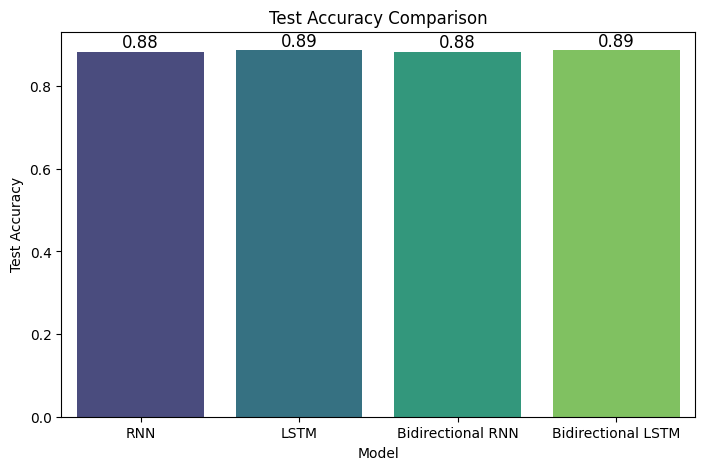

In [30]:
test_accs = {name: res['test_accuracy'] for name, res in results.items()}

plt.figure(figsize=(18,5))


plt.subplot(1,2,1)
sns.barplot(x=list(test_accs.keys()), y=list(test_accs.values()), palette='viridis')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
for i, (model_name, acc) in enumerate(test_accs.items()):
    plt.text(i, acc, f"{acc:.2f}", ha='center', va='bottom', fontsize=12, color='black')

# Training Losses

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


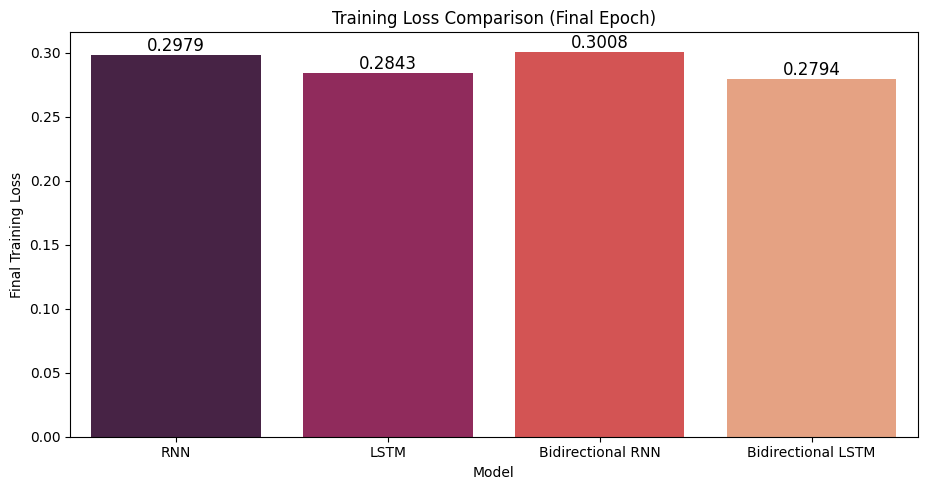

In [31]:

train_losses_final = {name: res['train_losses'][-1] for name, res in results.items()}
plt.figure(figsize=(18,5))

plt.subplot(1,2,2)
sns.barplot(x=list(train_losses_final.keys()), y=list(train_losses_final.values()), palette='rocket')
plt.xlabel('Model')
plt.ylabel('Final Training Loss')
plt.title('Training Loss Comparison (Final Epoch)')
for i, (model_name, loss_val) in enumerate(train_losses_final.items()):
    plt.text(i, loss_val, f"{loss_val:.4f}", ha='center', va='bottom', fontsize=12, color='black')

plt.tight_layout()
plt.show()